# Task 1: Exploratory Data Analysis and Data Preprocessing

## Objective
To understand the structure, content, and quality of the complaint data and prepare it for the RAG pipeline.

## Steps:
1. Load the full CFPB complaint dataset
2. Perform initial EDA to understand the data
3. Analyze distribution of complaints across products
4. Calculate and visualize narrative length
5. Filter dataset for target products
6. Clean text narratives
7. Save processed dataset

In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    pass

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 1. Data Loading

In [11]:
#  mount Dataset. unzip and read csv using with

from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Define the path to the zip file in your Drive
# Replace 'path/to/your/dataset.zip' with the actual path to your zip file
zip_path = '/content/drive/MyDrive/kaim 6/week6/complaints.csv.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # List all files in the zip
    csv_file_name = zip_ref.namelist()[0]  # assumes there's only one CSV
    with zip_ref.open(csv_file_name) as csv_file:
        df = pd.read_csv(csv_file)

print(df.head())

  Date received                                            Product  \
0    2025-06-20  Credit reporting or other personal consumer re...   
1    2025-06-20                                    Debt collection   
2    2025-06-20  Credit reporting or other personal consumer re...   
3    2025-06-20  Credit reporting or other personal consumer re...   
4    2025-06-20  Credit reporting or other personal consumer re...   

               Sub-product                                 Issue  \
0         Credit reporting  Incorrect information on your report   
1  Telecommunications debt     Attempts to collect debt not owed   
2         Credit reporting           Improper use of your report   
3         Credit reporting           Improper use of your report   
4         Credit reporting  Incorrect information on your report   

                                       Sub-issue Consumer complaint narrative  \
0            Information belongs to someone else                          NaN   
1       

In [17]:
try:
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Shape: {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
    print("❌ Dataset not found. Creating sample data for demonstration...")

# Display basic information
print(f"\n📋 Dataset Info:")
print(f"Columns: {list(df.columns)}")
df.head()

✅ Dataset loaded successfully!
📊 Shape: (9609797, 18)
💾 Memory usage: 13671.00 MB

📋 Dataset Info:
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


## 2. Initial Exploratory Data Analysis

In [18]:
# Basic dataset statistics
print("=== DATASET OVERVIEW ===")
print(f"Total records: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Date range: {df['Date received'].min()} to {df['Date received'].max()}")

# Missing values analysis
print("\n=== MISSING VALUES ANALYSIS ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Percentage', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

# Data types
print("\n=== DATA TYPES ===")
print(df.dtypes)

=== DATASET OVERVIEW ===
Total records: 9,609,797
Total columns: 18
Date range: 2011-12-01 to 2025-06-23

=== MISSING VALUES ANALYSIS ===
                              Missing Count  Missing Percentage
Tags                                8981029           93.457011
Consumer disputed?                  8841498           92.005044
Consumer complaint narrative        6629041           68.982113
Company public response             4770207           49.638999
Consumer consent provided?          1649561           17.165409
Sub-issue                            839522            8.736105
Sub-product                          235295            2.448491
State                                 54516            0.567296
ZIP code                              30228            0.314554
Company response to consumer             20            0.000208
Issue                                     6            0.000062

=== DATA TYPES ===
Date received                   object
Product                         obj

=== PRODUCT DISTRIBUTION ===
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           8

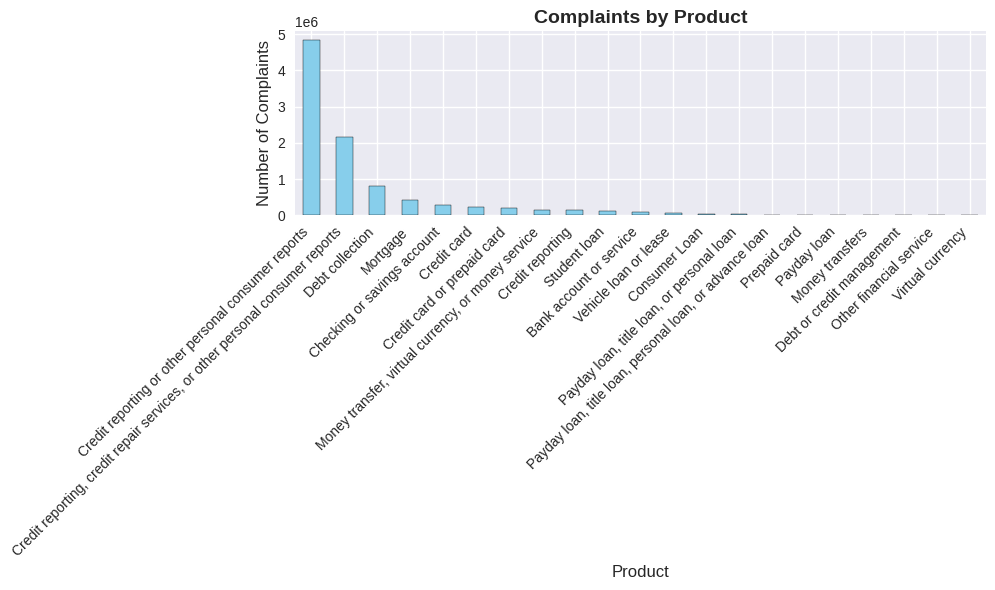


🥧 Showing Pie Chart of Product Distribution (%)...


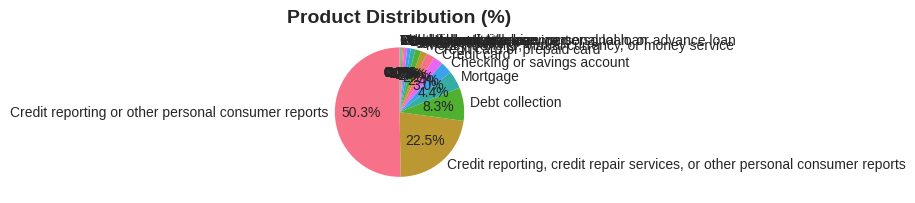


🧭 Showing Interactive Plotly Bar Chart...


In [22]:

# Product distribution analysis
print("=== PRODUCT DISTRIBUTION ===")
product_counts = df['Product'].value_counts()
print(product_counts)

# ---------- Plot 1: Matplotlib Bar Chart ----------
print("\n📊 Showing Bar Chart of Complaints by Product...")
plt.figure(figsize=(10, 6))
product_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Complaints by Product', fontsize=14, fontweight='bold')
plt.xlabel('Product', fontsize=12)
plt.ylabel('Number of Complaints', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ---------- Plot 2: Matplotlib Pie Chart ----------
print("\n🥧 Showing Pie Chart of Product Distribution (%)...")
plt.figure(figsize=(8, 8))
plt.pie(product_counts.values, labels=product_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Product Distribution (%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ---------- Plot 3: Interactive Plotly Bar Chart ----------
print("\n🧭 Showing Interactive Plotly Bar Chart...")
fig_plotly = px.bar(
    x=product_counts.index,
    y=product_counts.values,
    title='Complaint Distribution by Product (Interactive)',
    labels={'x': 'Product', 'y': 'Number of Complaints'},
    color=product_counts.values,
    color_continuous_scale='Blues'
)
fig_plotly.update_layout(xaxis_title='Product', yaxis_title='Number of Complaints', xaxis_tickangle=-45)
fig_plotly.show()


## 3. Consumer Complaint Narrative Analysis

In [23]:
# Analyze complaint narratives
narrative_col = 'Consumer complaint narrative'

print("=== NARRATIVE ANALYSIS ===")

# Check for narratives
has_narrative = df[narrative_col].notna() & (df[narrative_col] != '') & (df[narrative_col].str.strip() != '')
narrative_count = has_narrative.sum()
no_narrative_count = len(df) - narrative_count

print(f"Records with narratives: {narrative_count:,} ({narrative_count/len(df)*100:.1f}%)")
print(f"Records without narratives: {no_narrative_count:,} ({no_narrative_count/len(df)*100:.1f}%)")

# Calculate word counts for narratives
df['narrative_word_count'] = df[narrative_col].fillna('').apply(lambda x: len(str(x).split()))
df['narrative_char_count'] = df[narrative_col].fillna('').apply(lambda x: len(str(x)))

# Statistics for narratives with content
narrative_stats = df[has_narrative]['narrative_word_count'].describe()
print(f"\nWord Count Statistics (for records with narratives):")
print(narrative_stats)

char_stats = df[has_narrative]['narrative_char_count'].describe()
print(f"\nCharacter Count Statistics (for records with narratives):")
print(char_stats)

=== NARRATIVE ANALYSIS ===
Records with narratives: 2,980,756 (31.0%)
Records without narratives: 6,629,041 (69.0%)

Word Count Statistics (for records with narratives):
count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: narrative_word_count, dtype: float64

Character Count Statistics (for records with narratives):
count    2.980756e+06
mean     9.997596e+02
std      1.300031e+03
min      4.000000e+00
25%      3.330000e+02
50%      6.590000e+02
75%      1.189000e+03
max      3.572200e+04
Name: narrative_char_count, dtype: float64


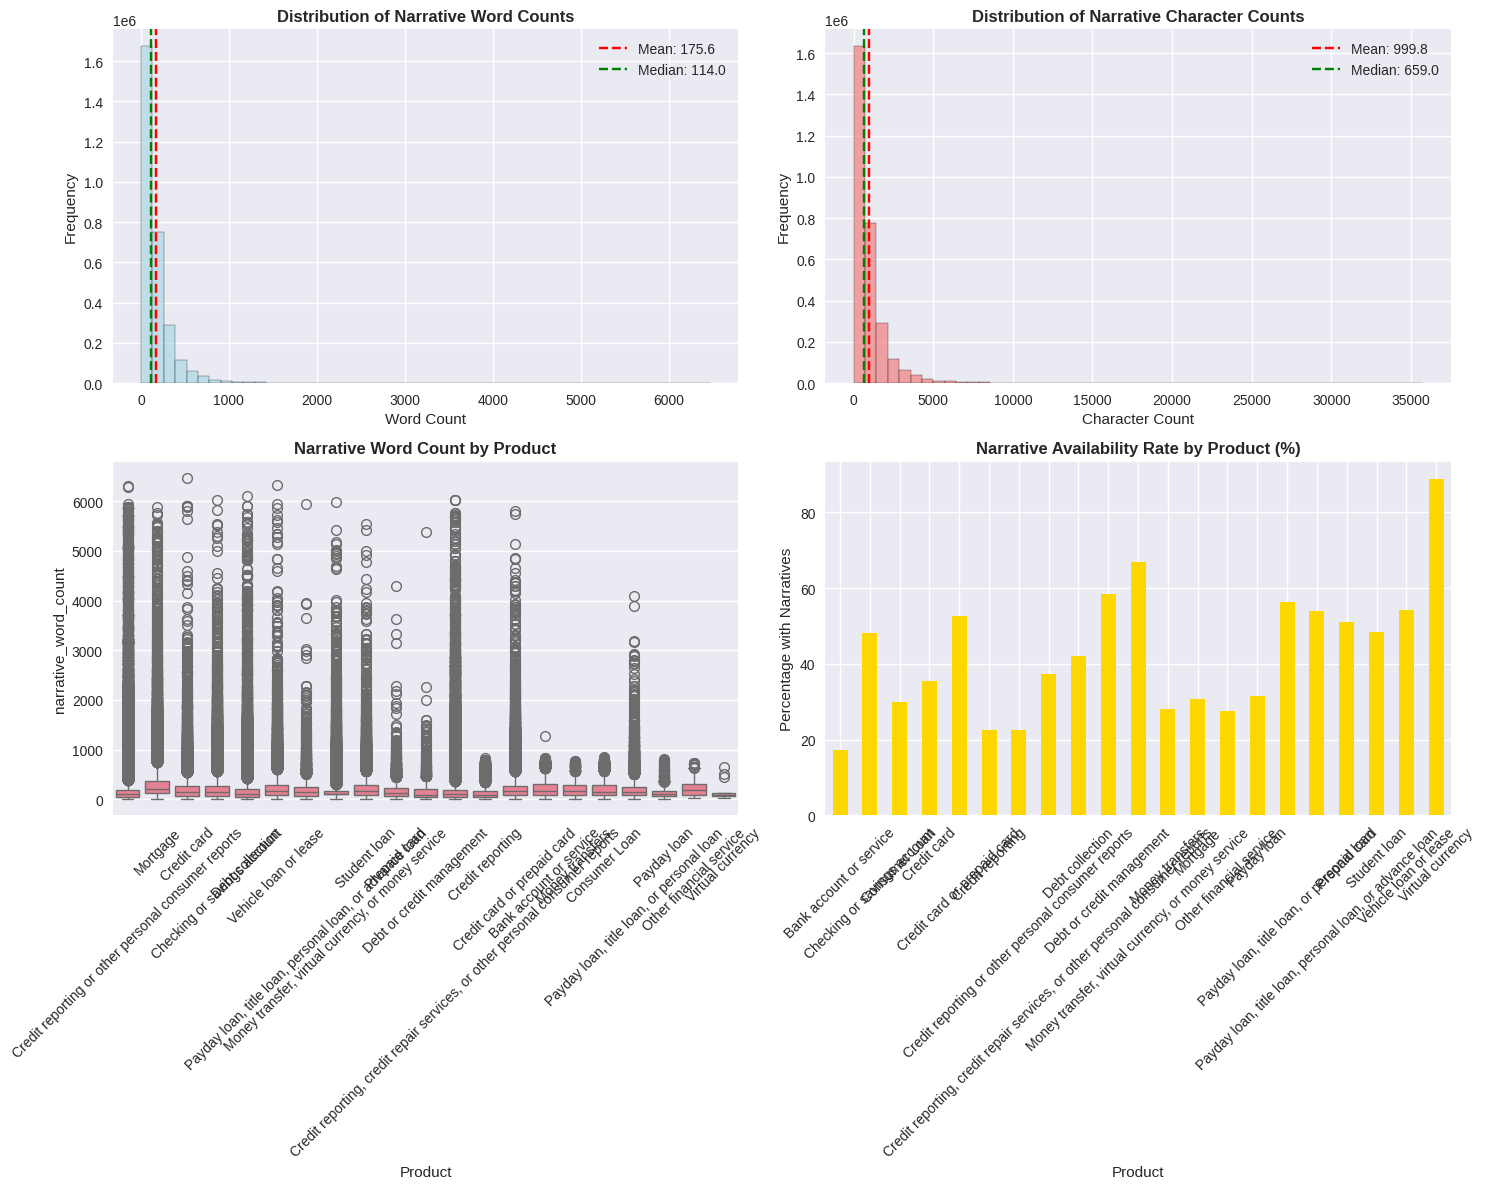


Narrative Availability by Product:
                                                    With_Narrative    Total  \
Product                                                                       
Bank account or service                                      14885    86205   
Checking or savings account                                 140319   291178   
Consumer Loan                                                 9461    31574   
Credit card                                                  80667   226686   
Credit card or prepaid card                                 108667   206369   
Credit reporting                                             31587   140429   
Credit reporting or other personal consumer rep...         1091253  4834855   
Credit reporting, credit repair services, or ot...          807281  2163857   
Debt collection                                             336076   799197   
Debt or credit management                                     2949     5047   
Money transfer, 

In [24]:
# Visualize narrative length distributions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Word count distribution
narrative_words = df[has_narrative]['narrative_word_count']
ax1.hist(narrative_words, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
ax1.set_title('Distribution of Narrative Word Counts', fontweight='bold')
ax1.set_xlabel('Word Count')
ax1.set_ylabel('Frequency')
ax1.axvline(narrative_words.mean(), color='red', linestyle='--', label=f'Mean: {narrative_words.mean():.1f}')
ax1.axvline(narrative_words.median(), color='green', linestyle='--', label=f'Median: {narrative_words.median():.1f}')
ax1.legend()

# Character count distribution
narrative_chars = df[has_narrative]['narrative_char_count']
ax2.hist(narrative_chars, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_title('Distribution of Narrative Character Counts', fontweight='bold')
ax2.set_xlabel('Character Count')
ax2.set_ylabel('Frequency')
ax2.axvline(narrative_chars.mean(), color='red', linestyle='--', label=f'Mean: {narrative_chars.mean():.1f}')
ax2.axvline(narrative_chars.median(), color='green', linestyle='--', label=f'Median: {narrative_chars.median():.1f}')
ax2.legend()

# Box plot for word counts by product
products_with_narratives = df[has_narrative]
sns.boxplot(data=products_with_narratives, x='Product', y='narrative_word_count', ax=ax3)
ax3.set_title('Narrative Word Count by Product', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# Narrative availability by product
narrative_by_product = df.groupby('Product').agg({
    narrative_col: lambda x: (x.notna() & (x != '') & (x.str.strip() != '')).sum(),
    'Product': 'count'
}).rename(columns={narrative_col: 'With_Narrative', 'Product': 'Total'})
narrative_by_product['Narrative_Rate'] = narrative_by_product['With_Narrative'] / narrative_by_product['Total'] * 100

narrative_by_product['Narrative_Rate'].plot(kind='bar', ax=ax4, color='gold')
ax4.set_title('Narrative Availability Rate by Product (%)', fontweight='bold')
ax4.set_ylabel('Percentage with Narratives')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nNarrative Availability by Product:")
print(narrative_by_product)

## 4. Issue and Company Analysis

=== ISSUE ANALYSIS ===
Top 10 Issues:
Issue
Incorrect information on your report                                                3613761
Improper use of your report                                                         1841256
Problem with a company's investigation into an existing problem                      928220
Problem with a credit reporting company's investigation into an existing problem     589334
Attempts to collect debt not owed                                                    314690
Managing an account                                                                  171233
Written notification about debt                                                      161161
Loan modification,collection,foreclosure                                             112306
Incorrect information on credit report                                               102684
Trouble during payment process                                                        94390
Name: count, dtype: int64


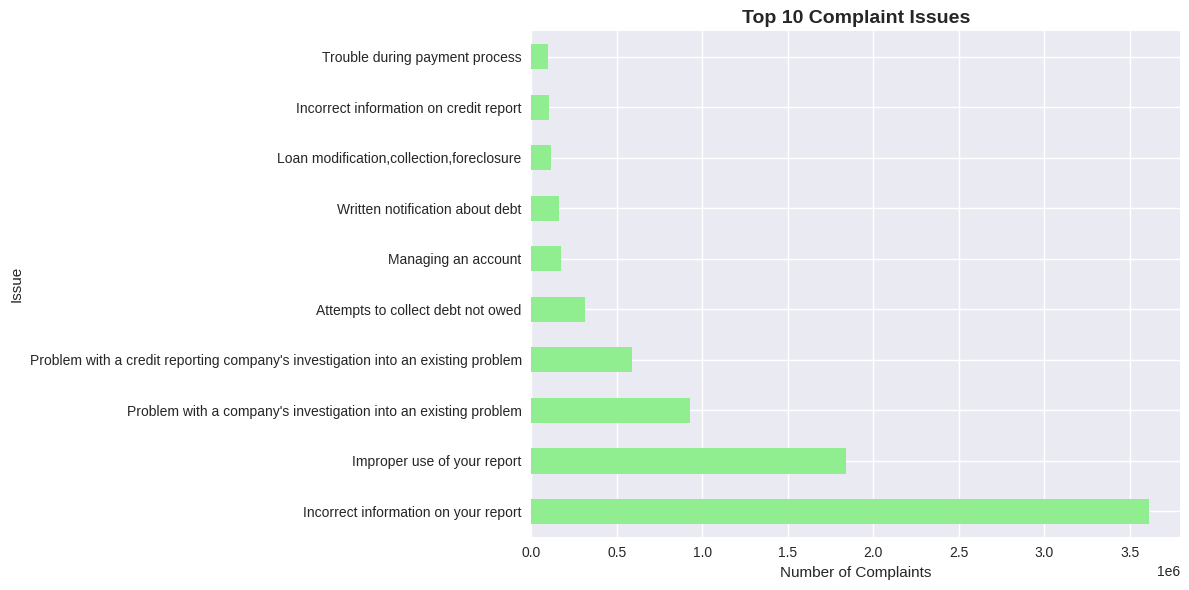


=== COMPANY ANALYSIS ===
Top 10 Companies by Complaint Volume:
Company
EQUIFAX, INC.                             2321626
TRANSUNION INTERMEDIATE HOLDINGS, INC.    2283823
Experian Information Solutions Inc.       2140828
BANK OF AMERICA, NATIONAL ASSOCIATION      157983
WELLS FARGO & COMPANY                      146922
JPMORGAN CHASE & CO.                       143015
CAPITAL ONE FINANCIAL CORPORATION          131046
CITIBANK, N.A.                             113122
SYNCHRONY FINANCIAL                         63656
Block, Inc.                                 51793
Name: count, dtype: int64

=== STATE ANALYSIS ===
Top 10 States by Complaint Volume:
State
FL    1273171
TX    1155509
CA    1005846
GA     695960
NY     613043
PA     425030
IL     412407
NJ     330823
NC     317330
MD     248407
Name: count, dtype: int64


In [25]:
# Analyze issues
print("=== ISSUE ANALYSIS ===")
issue_counts = df['Issue'].value_counts().head(10)
print("Top 10 Issues:")
print(issue_counts)

# Visualize top issues
plt.figure(figsize=(12, 6))
issue_counts.plot(kind='barh', color='lightgreen')
plt.title('Top 10 Complaint Issues', fontsize=14, fontweight='bold')
plt.xlabel('Number of Complaints')
plt.tight_layout()
plt.show()

# Company analysis
print("\n=== COMPANY ANALYSIS ===")
company_counts = df['Company'].value_counts().head(10)
print("Top 10 Companies by Complaint Volume:")
print(company_counts)

# State analysis
print("\n=== STATE ANALYSIS ===")
state_counts = df['State'].value_counts().head(10)
print("Top 10 States by Complaint Volume:")
print(state_counts)

## 5. Data Filtering for Target Products

In [26]:
# Define target products for CrediTrust Financial
target_products = [
    'Credit card',
    'Personal loan',
    'Buy Now, Pay Later (BNPL)',
    'Savings account',
    'Money transfers'
]

print("=== FILTERING FOR TARGET PRODUCTS ===")
print(f"Target products: {target_products}")

# Check which products exist in our dataset
available_products = df['Product'].unique()
print(f"\nAvailable products in dataset: {list(available_products)}")

# Create mapping for product variations
product_mapping = {
    'Credit card': ['Credit card', 'Credit card or prepaid card'],
    'Personal loan': ['Personal loan'],
    'Buy Now, Pay Later (BNPL)': ['Buy Now, Pay Later (BNPL)', 'BNPL'],
    'Savings account': ['Savings account', 'Checking or savings account'],
    'Money transfers': ['Money transfers', 'Money transfer', 'Money transfer, virtual currency, or money service']
}

# Filter for target products
target_product_variations = [item for sublist in product_mapping.values() for item in sublist]
df_filtered = df[df['Product'].isin(target_product_variations)].copy()

print(f"\nRecords before filtering: {len(df):,}")
print(f"Records after product filtering: {len(df_filtered):,}")
print(f"Records removed: {len(df) - len(df_filtered):,}")

# Show distribution after filtering
print(f"\nProduct distribution after filtering:")
filtered_product_counts = df_filtered['Product'].value_counts()
print(filtered_product_counts)

=== FILTERING FOR TARGET PRODUCTS ===
Target products: ['Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', 'Money transfers']

Available products in dataset: ['Credit reporting or other personal consumer reports', 'Debt collection', 'Credit card', 'Checking or savings account', 'Money transfer, virtual currency, or money service', 'Vehicle loan or lease', 'Debt or credit management', 'Mortgage', 'Payday loan, title loan, personal loan, or advance loan', 'Prepaid card', 'Student loan', 'Credit reporting', 'Credit reporting, credit repair services, or other personal consumer reports', 'Credit card or prepaid card', 'Payday loan, title loan, or personal loan', 'Bank account or service', 'Money transfers', 'Consumer Loan', 'Payday loan', 'Other financial service', 'Virtual currency']

Records before filtering: 9,609,797
Records after product filtering: 874,653
Records removed: 8,735,144

Product distribution after filtering:
Product
Checking or savings account 

In [27]:
# Remove records without narratives
print("=== REMOVING RECORDS WITHOUT NARRATIVES ===")

before_narrative_filter = len(df_filtered)
df_filtered = df_filtered[
    df_filtered[narrative_col].notna() &
    (df_filtered[narrative_col] != '') &
    (df_filtered[narrative_col].str.strip() != '')
].copy()

print(f"Records before narrative filtering: {before_narrative_filter:,}")
print(f"Records after narrative filtering: {len(df_filtered):,}")
print(f"Records removed: {before_narrative_filter - len(df_filtered):,}")

if len(df_filtered) == 0:
    print("❌ No records remaining after filtering. Check your dataset.")
else:
    print(f"✅ {len(df_filtered):,} records ready for processing")

=== REMOVING RECORDS WITHOUT NARRATIVES ===
Records before narrative filtering: 874,653
Records after narrative filtering: 428,338
Records removed: 446,315
✅ 428,338 records ready for processing


## 6. Text Cleaning and Normalization

In [28]:
def clean_text(text):
    """Clean and normalize text narratives"""
    if pd.isna(text) or text == '':
        return ''

    text = str(text).lower()

    # Remove common boilerplate text
    boilerplate_patterns = [
        r'i am writing to file a complaint',
        r'dear sir/madam',
        r'to whom it may concern',
        r'i would like to file a complaint',
        r'this is a complaint about'
    ]

    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("=== TEXT CLEANING ===")
print("Cleaning complaint narratives...")

# Apply text cleaning
df_filtered['cleaned_narrative'] = df_filtered[narrative_col].apply(clean_text)

# Calculate word counts for cleaned text
df_filtered['cleaned_word_count'] = df_filtered['cleaned_narrative'].apply(lambda x: len(str(x).split()))
df_filtered['cleaned_char_count'] = df_filtered['cleaned_narrative'].apply(lambda x: len(str(x)))

# Remove very short narratives (less than 10 words)
before_length_filter = len(df_filtered)
df_filtered = df_filtered[df_filtered['cleaned_word_count'] >= 10].copy()

print(f"Records before length filtering: {before_length_filter:,}")
print(f"Records after length filtering (>=10 words): {len(df_filtered):,}")
print(f"Records removed: {before_length_filter - len(df_filtered):,}")

# Show examples of cleaning
print("\n=== CLEANING EXAMPLES ===")
for i in range(min(3, len(df_filtered))):
    original = df_filtered.iloc[i][narrative_col][:100]
    cleaned = df_filtered.iloc[i]['cleaned_narrative'][:100]
    print(f"\nExample {i+1}:")
    print(f"Original: {original}...")
    print(f"Cleaned:  {cleaned}...")

=== TEXT CLEANING ===
Cleaning complaint narratives...
Records before length filtering: 428,338
Records after length filtering (>=10 words): 426,490
Records removed: 1,848

=== CLEANING EXAMPLES ===

Example 1:
Original: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an acc...
Cleaned:  a xxxx xxxx card was opened under my name by a fraudster. i received a notice from xxxx that an acco...

Example 2:
Original: I made the mistake of using my wellsfargo debit card to depsit funds Into XXXXXXXX ATM machine outsi...
Cleaned:  i made the mistake of using my wellsfargo debit card to depsit funds into xxxxxxxx atm machine outsi...

Example 3:
Original: Dear CFPB, I have a secured credit card with citibank which is changed to unsecured card and I have ...
Cleaned:  dear cfpb, i have a secured credit card with citibank which is changed to unsecured card and i have ...


## 7. Final Dataset Statistics and Visualization

In [29]:
print("=== FINAL DATASET STATISTICS ===")

# Overall statistics
print(f"Total final records: {len(df_filtered):,}")
print(f"Average narrative length: {df_filtered['cleaned_word_count'].mean():.1f} words")
print(f"Median narrative length: {df_filtered['cleaned_word_count'].median():.1f} words")
print(f"Min narrative length: {df_filtered['cleaned_word_count'].min()} words")
print(f"Max narrative length: {df_filtered['cleaned_word_count'].max()} words")

# Product distribution in final dataset
print("\nFinal product distribution:")
final_product_dist = df_filtered['Product'].value_counts()
for product, count in final_product_dist.items():
    print(f"  - {product}: {count:,} complaints ({count/len(df_filtered)*100:.1f}%)")

# Issue distribution in final dataset
print("\nTop issues in final dataset:")
final_issue_dist = df_filtered['Issue'].value_counts().head(10)
for issue, count in final_issue_dist.items():
    print(f"  - {issue}: {count:,} complaints")

=== FINAL DATASET STATISTICS ===
Total final records: 426,490
Average narrative length: 206.7 words
Median narrative length: 138.0 words
Min narrative length: 10 words
Max narrative length: 6581 words

Final product distribution:
  - Checking or savings account: 139,513 complaints (32.7%)
  - Credit card or prepaid card: 108,292 complaints (25.4%)
  - Money transfer, virtual currency, or money service: 96,837 complaints (22.7%)
  - Credit card: 80,354 complaints (18.8%)
  - Money transfers: 1,494 complaints (0.4%)

Top issues in final dataset:
  - Managing an account: 75,326 complaints
  - Other transaction problem: 49,335 complaints
  - Problem with a purchase shown on your statement: 40,438 complaints
  - Fraud or scam: 20,215 complaints
  - Other features, terms, or problems: 19,622 complaints
  - Closing an account: 19,157 complaints
  - Fees or interest: 17,986 complaints
  - Getting a credit card: 17,572 complaints
  - Problem with a lender or other company charging your account:

In [30]:
# Create comprehensive visualization of final dataset
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Final Product Distribution', 'Cleaned Narrative Length Distribution',
                   'Top Issues', 'Complaints Over Time'),
    specs=[[{"type": "bar"}, {"type": "histogram"}],
           [{"type": "bar"}, {"type": "scatter"}]]
)

# Product distribution
fig.add_trace(
    go.Bar(x=final_product_dist.index, y=final_product_dist.values, name="Products"),
    row=1, col=1
)

# Narrative length distribution
fig.add_trace(
    go.Histogram(x=df_filtered['cleaned_word_count'], nbinsx=30, name="Word Count"),
    row=1, col=2
)

# Top issues
top_issues = final_issue_dist.head(8)
fig.add_trace(
    go.Bar(x=top_issues.values, y=top_issues.index, orientation='h', name="Issues"),
    row=2, col=1
)

# Complaints over time
df_filtered['Date received'] = pd.to_datetime(df_filtered['Date received'], errors='coerce')
monthly_complaints = df_filtered.groupby(df_filtered['Date received'].dt.to_period('M')).size()
fig.add_trace(
    go.Scatter(x=monthly_complaints.index.astype(str), y=monthly_complaints.values,
              mode='lines+markers', name="Monthly Complaints"),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False,
                 title_text="Final Dataset Analysis - Ready for RAG Pipeline")
fig.show()

## 8. Generate Word Clouds

=== GENERATING WORD CLOUDS ===


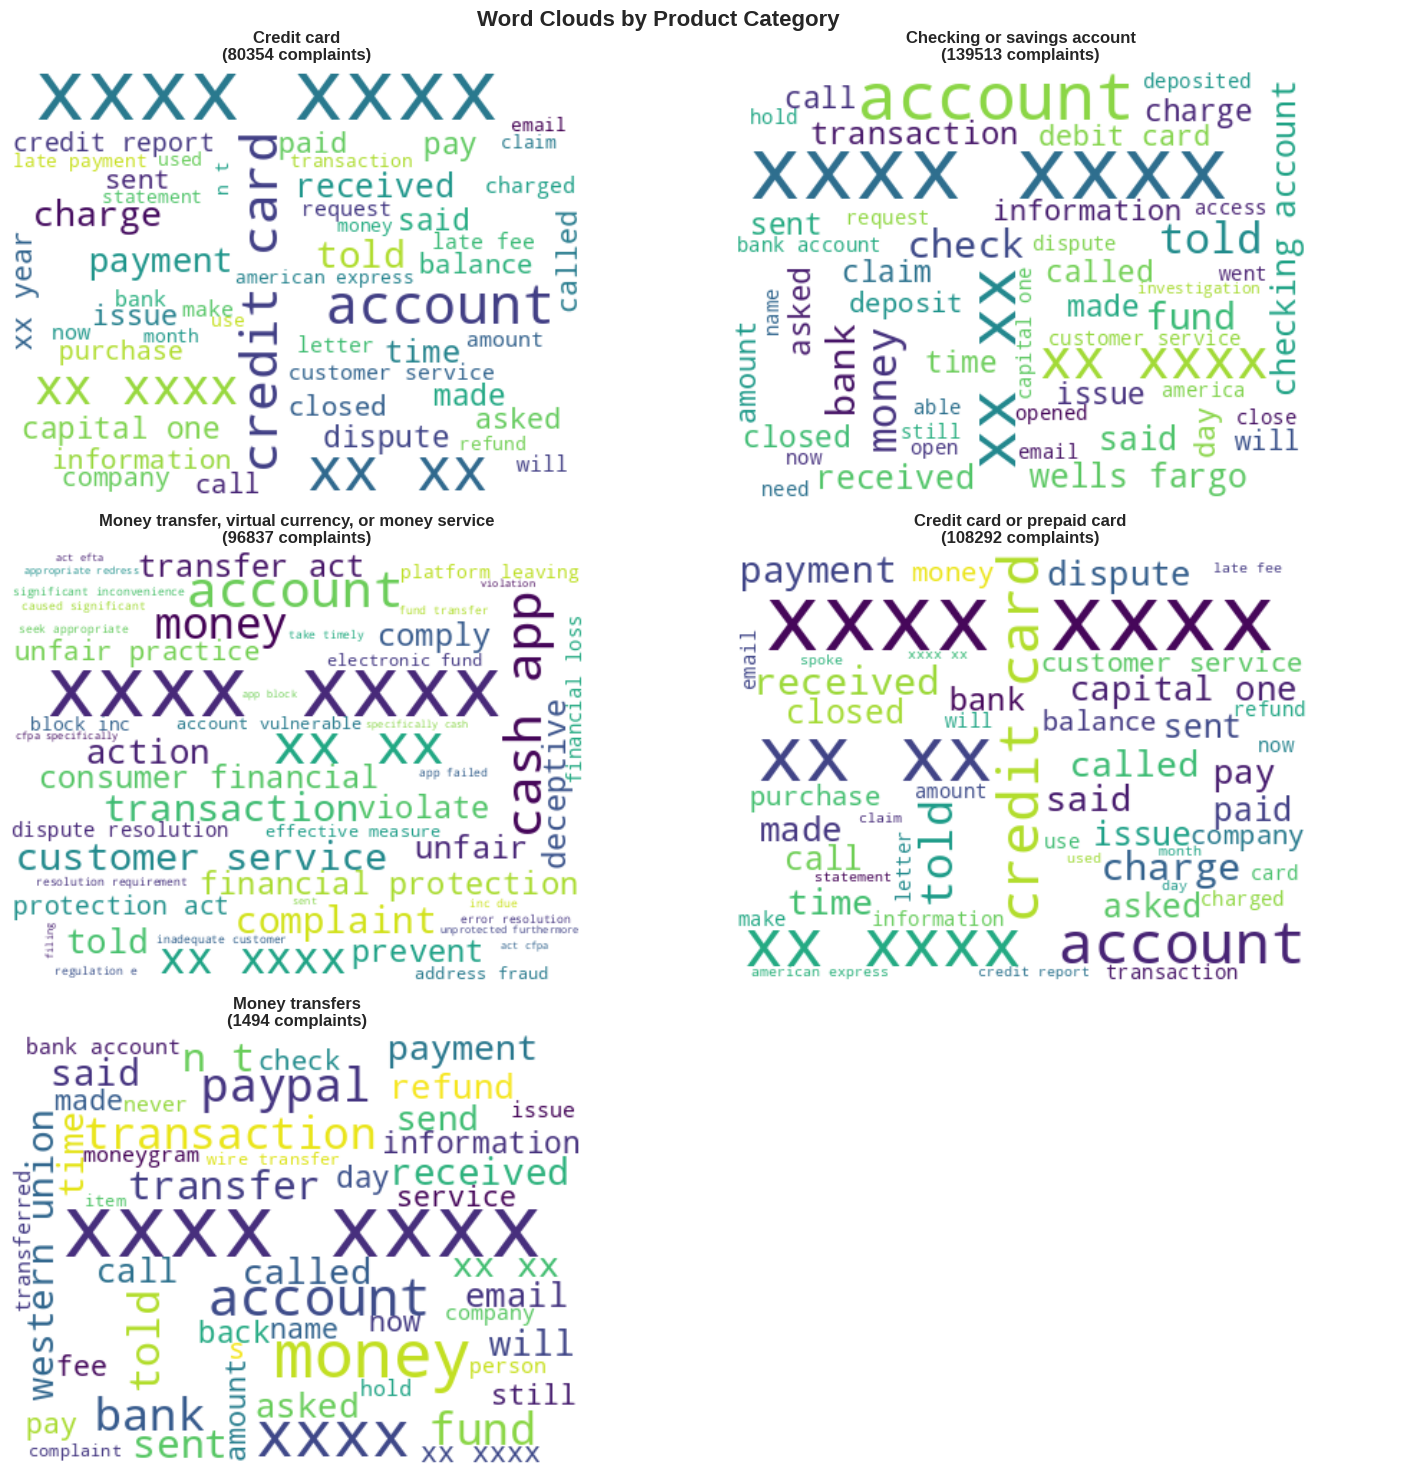

✅ Word clouds generated for 5 products


In [31]:
# Generate word clouds for each product
print("=== GENERATING WORD CLOUDS ===")

products = df_filtered['Product'].unique()
n_products = len(products)
cols = 2
rows = (n_products + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for i, product in enumerate(products):
    row = i // cols
    col = i % cols

    # Get text for this product
    product_text = df_filtered[df_filtered['Product'] == product]['cleaned_narrative'].str.cat(sep=' ')

    if len(product_text) > 0:
        # Create word cloud
        wordcloud = WordCloud(width=400, height=300,
                             background_color='white',
                             max_words=50,
                             colormap='viridis').generate(product_text)

        axes[row, col].imshow(wordcloud, interpolation='bilinear')
        axes[row, col].set_title(f'{product}\n({len(df_filtered[df_filtered["Product"] == product])} complaints)',
                               fontweight='bold')
        axes[row, col].axis('off')
    else:
        axes[row, col].text(0.5, 0.5, 'No data', ha='center', va='center')
        axes[row, col].set_title(product)
        axes[row, col].axis('off')

# Hide empty subplots
for i in range(n_products, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis('off')

plt.suptitle('Word Clouds by Product Category', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✅ Word clouds generated for {len(products)} products")

## 9. Save Processed Dataset

In [33]:
# Save the processed dataset
import os

print("=== SAVING PROCESSED DATASET ===")


# Save filtered and cleaned dataset
output_path = 'filtered_complaints.csv'
df_filtered.to_csv(output_path, index=False)

print(f"✅ Processed dataset saved to: {output_path}")
print(f"📊 Saved {len(df_filtered):,} records with {len(df_filtered.columns)} columns")

# Save summary statistics
summary_stats = {
    'total_records': len(df_filtered),
    'products': df_filtered['Product'].unique().tolist(),
    'avg_word_count': df_filtered['cleaned_word_count'].mean(),
    'median_word_count': df_filtered['cleaned_word_count'].median(),
    'date_range': {
        'start': str(df_filtered['Date received'].min()),
        'end': str(df_filtered['Date received'].max())
    },
    'product_distribution': df_filtered['Product'].value_counts().to_dict()
}

import json
with open('dataset_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)

print(f"✅ Summary statistics saved to: ../data/dataset_summary.json")

# Display final summary
print("\n" + "="*50)
print("🎉 TASK 1 COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"📊 Final Dataset: {len(df_filtered):,} complaint records")
print(f"🏷️  Products: {len(df_filtered['Product'].unique())} categories")
print(f"📝 Average narrative: {df_filtered['cleaned_word_count'].mean():.1f} words")
print(f"💾 Saved to: {output_path}")
print("\n🚀 Ready for Task 2: Text Chunking and Embedding Creation")

=== SAVING PROCESSED DATASET ===
✅ Processed dataset saved to: filtered_complaints.csv
📊 Saved 426,490 records with 23 columns
✅ Summary statistics saved to: ../data/dataset_summary.json

🎉 TASK 1 COMPLETED SUCCESSFULLY!
📊 Final Dataset: 426,490 complaint records
🏷️  Products: 5 categories
📝 Average narrative: 206.7 words
💾 Saved to: filtered_complaints.csv

🚀 Ready for Task 2: Text Chunking and Embedding Creation
